In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [3]:
def conv_block(x, filters, kernel_size, strides=2):
    """
    Convolutional block with shortcut connection for downsampling.
    """
    # Shortcut
    shortcut = Conv2D(filters * 4, kernel_size=(1, 1), strides=strides, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    # First convolution
    x = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third convolution
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut and pass through activation
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [4]:
#skip connection
def identity_block(x, filters, kernel_size):
    """
    Identity block with no downsampling.
    """
    shortcut = x

    # First convolution
    x = Conv2D(filters, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution(3x3 kernel size)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third convolution
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut and pass through activation
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [5]:
def resnet50(input_shape=(224, 224, 3), num_classes=1000):
    """
    Builds the ResNet-50 model from scratch.
    """
    inputs = Input(shape=input_shape)

    # Initial Convolution and MaxPooling
    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual Blocks
    # Conv Block + Identity Blocks
    x = conv_block(x, filters=64, kernel_size=3, strides=1)  # Block 1
    for _ in range(2):
        x = identity_block(x, filters=64, kernel_size=3)

    x = conv_block(x, filters=128, kernel_size=3)  # Block 2
    for _ in range(3):
        x = identity_block(x, filters=128, kernel_size=3)

    x = conv_block(x, filters=256, kernel_size=3)  # Block 3
    for _ in range(5):
        x = identity_block(x, filters=256, kernel_size=3)

    x = conv_block(x, filters=512, kernel_size=3)  # Block 4
    for _ in range(2):
        x = identity_block(x, filters=512, kernel_size=3)

    # Global Average Pooling and Output Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [6]:
# Define model for CIFAR-10 with 10 classes
model = resnet50(input_shape=(32, 32, 3), num_classes=10)
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 16, 16, 64)        │           9,472 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 16, 16, 64)        │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 16, 16, 64)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 8, 8, 64)          │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 8, 8, 64)          │           4,160 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 8, 8, 64)          │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 8, 8, 64)          │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 8, 8, 64)          │          36,928 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 8, 8, 64)          │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 8, 8, 64)          │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 8, 8, 256)         │          16,640 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 8, 8, 256)         │          16,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 8, 8, 256)         │           1,024 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 8, 8, 256)         │           1,024 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │               

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5,
    batch_size=64,
    verbose=1
)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 869s 1s/step - accuracy: 0.3579 - loss: 1.9907 - val_accuracy: 0.3976 - val_loss: 7.9996
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1130s 1s/step - accuracy: 0.3963 - loss: 1.9220 - val_accuracy: 0.2946 - val_loss: 6.9624
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 820s 1s/step - accuracy: 0.4050 - loss: 1.8743 - val_accuracy: 0.3286 - val_loss: 31.0529
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 679s 869ms/step - accuracy: 0.4815 - loss: 1.5716 - val_accuracy: 0.5145 - val_loss: 2.0850
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 667s 848ms/step - accuracy: 0.5399 - loss: 1.4490 - val_accuracy: 0.1000 - val_loss: 2513.6514


In [12]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


313/313 - 42s - 133ms/step - accuracy: 0.1000 - loss: 2513.6509
Test Accuracy: 10.00%


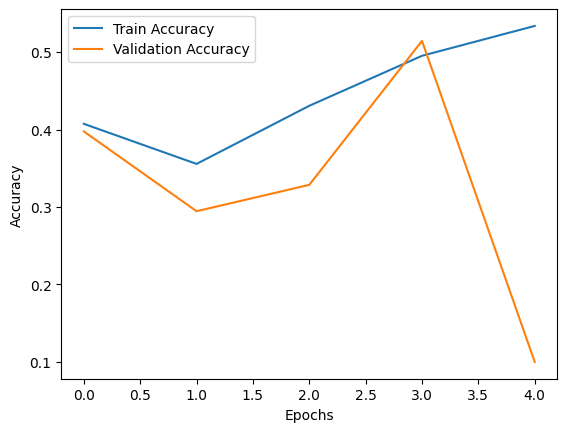

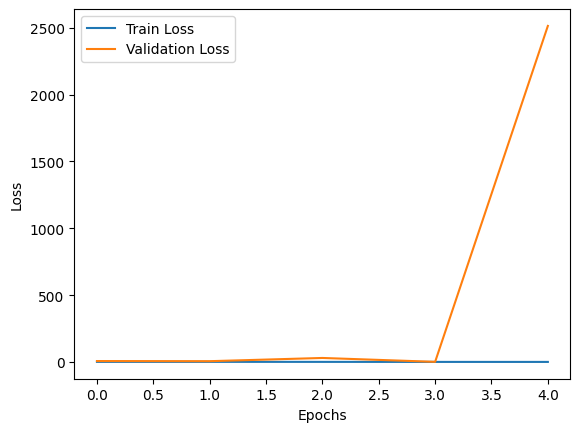

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
#data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    epochs=5,
    verbose=1
)


C:\Users\sudik\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 722s 869ms/step - accuracy: 0.4388 - loss: 1.7238 - val_accuracy: 0.3762 - val_loss: 1.8659
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 940s 1s/step - accuracy: 0.5154 - loss: 1.4736 - val_accuracy: 0.1792 - val_loss: 380.7903
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 430s 549ms/step - accuracy: 0.5627 - loss: 1.3508 - val_accuracy: 0.4879 - val_loss: 1.5415
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 425s 544ms/step - accuracy: 0.6008 - loss: 1.2773 - val_accuracy: 0.5667 - val_loss: 1.3873
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 421s 538ms/step - accuracy: 0.5701 - loss: 1.3259 - val_accuracy: 0.5589 - val_loss: 1.2284


In [15]:
#learning rate scheduling(Reduces lr after 10 epochs)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 0.001 * (0.1 ** (epoch // 10))
)
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5,
    batch_size=64,
    callbacks=[lr_schedule],
    verbose=1
)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 416s 532ms/step - accuracy: 0.5898 - loss: 1.2744 - val_accuracy: 0.3609 - val_loss: 68.1347 - learning_rate: 0.0010
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 416s 532ms/step - accuracy: 0.6517 - loss: 1.0859 - val_accuracy: 0.4753 - val_loss: 1.5129 - learning_rate: 0.0010
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 417s 533ms/step - accuracy: 0.6494 - loss: 1.1429 - val_accuracy: 0.6196 - val_loss: 4.5891 - learning_rate: 0.0010
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 416s 532ms/step - accuracy: 0.6945 - loss: 0.9578 - val_accuracy: 0.6730 - val_loss: 0.9919 - learning_rate: 0.0010
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 417s 533ms/step - accuracy: 0.7058 - loss: 0.8698 - val_accuracy: 0.4065 - val_loss: 1.8859 - learning_rate: 0.0010
